<a href="https://colab.research.google.com/github/punchnami/AI-Powered-Research-Query-Chatbot/blob/main/final_predictive_model_sarimax_using_differencing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Needed Libraries

In [2]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import warnings

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss

# Data Cleaning & Merging

## Search Sheet

In [3]:
search_file_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/1. BGCR; SOFR/Search.xlsx'
df = pd.read_excel(search_file_path)
df_cleaned = df.dropna(axis=1, how='all')
df_cleaned = df_cleaned.drop(columns=['Footnote ID'])
df_cleaned = df_cleaned[df_cleaned['Rate Type'] == 'BGCR']
df_BGCR = df_cleaned.copy()
df_BGCR = df_BGCR.rename(columns={'Effective Date': 'Date'})

## Daily Treasury Rates Sheet

In [4]:
d_treas_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/2 3. Treasury Yield; Yield Spread; Federal'
files_to_concatenate = [
    'daily-treasury-rates_2018.csv',
    'daily-treasury-rates_2019.csv',
    'daily-treasury-rates_2020.csv',
    'daily-treasury-rates_2021.csv',
    'daily-treasury-rates_2022.csv',
    'daily-treasury-rates_2023.csv',
    'daily-treasury-rates_2024.csv'
]
df_list = []
for file in files_to_concatenate:
    file_path = os.path.join(d_treas_path, file)
    df = pd.read_csv(file_path)
    df_list.append(df)
merged_df = pd.concat(df_list, ignore_index=True)
merged_df = merged_df.dropna(axis=1, how='all')
if 'Footnote ID' in merged_df.columns:
    merged_df = merged_df.drop(columns=['Footnote ID'])
merged_daily_treasury_rates = merged_df.copy()

## Daily Treasury Rates LT Sheet

In [5]:
files_to_concatenate = [
    'daily-treasury-rates_LT_2018.csv',
    'daily-treasury-rates_LT_2019.csv',
    'daily-treasury-rates_LT_2020.csv',
    'daily-treasury-rates_LT_2021.csv',
    'daily-treasury-rates_LT_2022.csv',
    'daily-treasury-rates_LT_2023.csv',
    'daily-treasury-rates_LT_2024.csv'
]
df_list = []
for file in files_to_concatenate:
    file_path = os.path.join(d_treas_path, file)
    df = pd.read_csv(file_path)
    df_list.append(df)
merged_df = pd.concat(df_list, ignore_index=True)
merged_df = merged_df.dropna(axis=1, how='all')
if 'Footnote ID' in merged_df.columns:
    merged_df = merged_df.drop(columns=['Footnote ID'])
merged_daily_treasury_LT_rates = merged_df.copy()

df_merged = pd.merge(merged_daily_treasury_rates, merged_daily_treasury_LT_rates, on='Date', how='inner')

## Feature Additions

In [6]:
# Calculate short-term yield spreads
df_merged['Yield Spread (4W - 52W)'] = df_merged['52 WEEKS COUPON EQUIVALENT'] - df_merged['4 WEEKS COUPON EQUIVALENT']
df_merged['Yield Spread (13W - 52W)'] = df_merged['52 WEEKS COUPON EQUIVALENT'] - df_merged['13 WEEKS COUPON EQUIVALENT']
df_merged['Yield Spread (26W - 52W)'] = df_merged['52 WEEKS COUPON EQUIVALENT'] - df_merged['26 WEEKS COUPON EQUIVALENT']

# Calculate long-term yield spreads
df_merged['Yield Spread (10Y - 4W)'] = df_merged['LT COMPOSITE (>10 Yrs)'] - df_merged['4 WEEKS COUPON EQUIVALENT']
df_merged['Yield Spread (20Y - 4W)'] = df_merged['TREASURY 20-Yr CMT'] - df_merged['4 WEEKS COUPON EQUIVALENT']
df_merged['Yield Spread (10Y - 52W)'] = df_merged['LT COMPOSITE (>10 Yrs)'] - df_merged['52 WEEKS COUPON EQUIVALENT']
df_merged['Yield Spread (20Y - 52W)'] = df_merged['TREASURY 20-Yr CMT'] - df_merged['52 WEEKS COUPON EQUIVALENT']

## Columns to Keep

In [7]:
columns_to_keep = [
    'Date',
    '4 WEEKS COUPON EQUIVALENT',
    '13 WEEKS COUPON EQUIVALENT',
    '26 WEEKS COUPON EQUIVALENT',
    '52 WEEKS COUPON EQUIVALENT',
    'LT COMPOSITE (>10 Yrs)',
    'TREASURY 20-Yr CMT',
    'Yield Spread (4W - 52W)',
    'Yield Spread (13W - 52W)',
    'Yield Spread (26W - 52W)',
    'Yield Spread (10Y - 4W)',
    'Yield Spread (20Y - 4W)',
    'Yield Spread (10Y - 52W)',
    'Yield Spread (20Y - 52W)'
]
df_relevant = df_merged[columns_to_keep]

df_merged = pd.merge(df_BGCR, df_relevant, on='Date', how='inner')
df_merged['Date'] = pd.to_datetime(df_merged['Date'])

## Add CPI

In [8]:
cpi_data = {
    'Year': [2018, 2019, 2020, 2021, 2022, 2023, 2024],
    'Jan': [247.867, 251.712, 257.971, 261.582, 281.148, 299.170, 308.417],
    'Feb': [248.991, 252.776, 258.678, 263.014, 283.716, 300.840, 310.326],
    'Mar': [249.554, 254.202, 258.115, 264.877, 287.504, 301.836, 312.332],
    'Apr': [250.546, 255.548, 256.389, 267.054, 289.109, 303.363, 313.548],
    'May': [251.588, 256.092, 256.934, 269.195, 292.296, 304.127, 314.069],
    'Jun': [251.988, 256.143, 257.797, 271.696, 296.311, 305.109, 314.069],
    'Jul': [252.006, 256.571, 259.101, 273.003, 296.276, 305.691, None],
    'Aug': [252.146, 256.558, 259.918, 273.567, 296.171, 307.026, None],
    'Sep': [252.439, 256.759, 260.280, 274.310, 296.908, 307.789, None],
    'Oct': [252.885, 257.346, 260.388, 276.589, 298.012, 307.671, None],
    'Nov': [252.038, 257.346, 260.229, 277.948, 297.711, 307.051, None],
    'Dec': [251.233, 257.208, 260.474, 278.802, 296.797, 306.746, None]
}


cpi_df = pd.DataFrame(cpi_data)
cpi_long_df = pd.melt(cpi_df, id_vars=['Year'], var_name='Month', value_name='CPI')
month_mapping = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}
cpi_long_df['Month'] = cpi_long_df['Month'].map(month_mapping)
cpi_long_df['Day'] = 1
cpi_long_df['Date'] = pd.to_datetime(cpi_long_df[['Year', 'Month', 'Day']])
cpi_long_df.drop(['Year', 'Month', 'Day'], axis=1, inplace=True)
cpi_long_df.set_index('Date', inplace=True)
cpi_long_df = cpi_long_df.resample('D').ffill()
cpi_long_df.reset_index(inplace=True)
cpi_long_df['Date'] = pd.to_datetime(cpi_long_df['Date'])

df_merged2 = pd.merge(df_merged, cpi_long_df[['Date', 'CPI']], on='Date', how='left')

## Add SPX

In [9]:
spx_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/6. Stock Market Data/HistoricalData_1719610851813_SPX.csv'
df = pd.read_csv(spx_path)
df = df.drop(columns=['Open', 'High', 'Low'])
df = df.rename(columns={'Close/Last': 'SPX'})
df['Date'] = pd.to_datetime(df['Date'])

df_merged3 = pd.merge(df_merged2, df, on='Date', how='inner')

## Add NASDAQ

In [10]:
nasdaq_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/6. Stock Market Data/HistoricalData_1719611009685_COMP.csv'
df = pd.read_csv(nasdaq_path)
df = df.drop(columns=['Open', 'High', 'Low'])
df = df.rename(columns={'Close/Last': 'NASDAQ'})
df['Date'] = pd.to_datetime(df['Date'])

df_merged4 = pd.merge(df_merged3, df, on='Date', how='inner')

## Add DJIA

In [11]:
djia_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/6. Stock Market Data/HistoricalPrices_DJIA.csv'
df = pd.read_csv(djia_path)
df = df.drop(columns=[' Open', ' High', ' Low'], axis=1)
df = df.rename(columns={' Close': 'DJIA'})
df['Date'] = pd.to_datetime(df['Date'])

df_merged5 = pd.merge(df_merged4, df, on='Date', how='inner')

<ipython-input-11-884830d5858d>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


## Add ForEx

In [12]:
forex_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/7. FX/FRB_H10.csv'
df = pd.read_csv(forex_path)
df = df.iloc[5:]
df.rename(columns={'Series Description': 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])

df_merged6 = pd.merge(df_merged5, df, on='Date', how='inner')

## Final Feature Set

In [13]:
df_final = df_merged6.copy()
df_final = df_final.drop(columns=[ 'Rate Type','1st Percentile (%)', '25th Percentile (%)', '75th Percentile (%)', '99th Percentile (%)'])

# Set the 'Date' column as the index
df_final.set_index('Date', inplace=True)
df_final2 = df_final.sort_index(ascending=True)
df_final2

# Replace 'ND' with NaN and fill with a method or drop rows
df_final2.replace('ND', np.nan, inplace=True)

print("NaN values in original features dataframe before dropping:")
print(df_final2.isna().sum())

# Drop rows with NaN values in the dataframe
df_final2.dropna(inplace=True)

cols = ['SPOT EXCHANGE RATE - EURO AREA ', 'UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)', 'CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R. ', 'JAPAN -- SPOT EXCHANGE RATE, YEN/US$ ']
df_final2[cols] = df_final2[cols].astype(float)

# Re-check for any remaining NaN values
print("\n\nNaN values in original features dataframe after dropping:")
print(df_final2.isna().sum())

NaN values in original features dataframe before dropping:
Rate (%)                                                          0
Volume ($Billions)                                                0
4 WEEKS COUPON EQUIVALENT                                         0
13 WEEKS COUPON EQUIVALENT                                        0
26 WEEKS COUPON EQUIVALENT                                        0
52 WEEKS COUPON EQUIVALENT                                        0
LT COMPOSITE (>10 Yrs)                                            0
TREASURY 20-Yr CMT                                                0
Yield Spread (4W - 52W)                                           0
Yield Spread (13W - 52W)                                          0
Yield Spread (26W - 52W)                                          0
Yield Spread (10Y - 4W)                                           0
Yield Spread (20Y - 4W)                                           0
Yield Spread (10Y - 52W)                                 

## Checking for Seasonality

### Visual Inspection

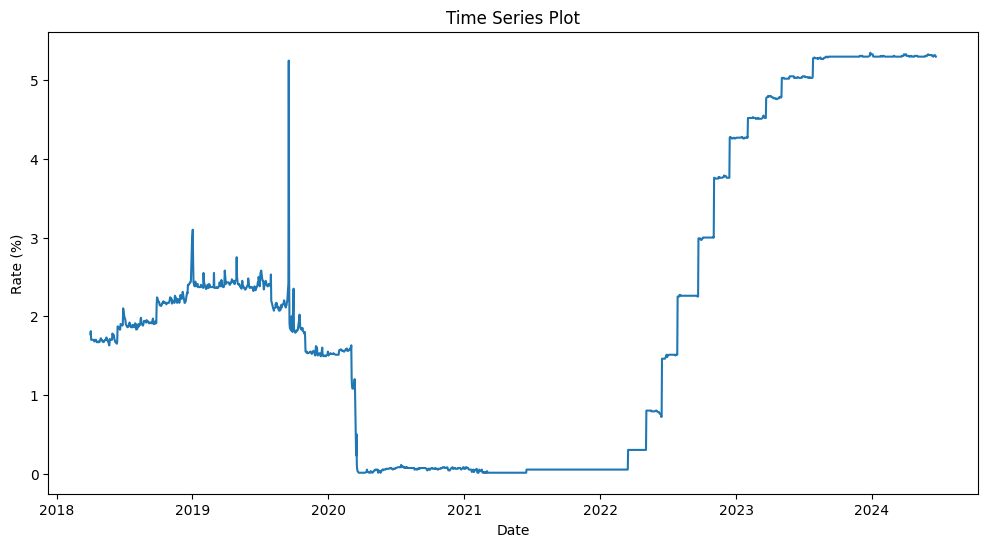

In [14]:
df_seasons= df_final2.copy()

plt.figure(figsize=(12, 6))
plt.plot(df_seasons.index, df_seasons['Rate (%)'])
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Rate (%)')
plt.show()

### Seasonal Subseries Plot

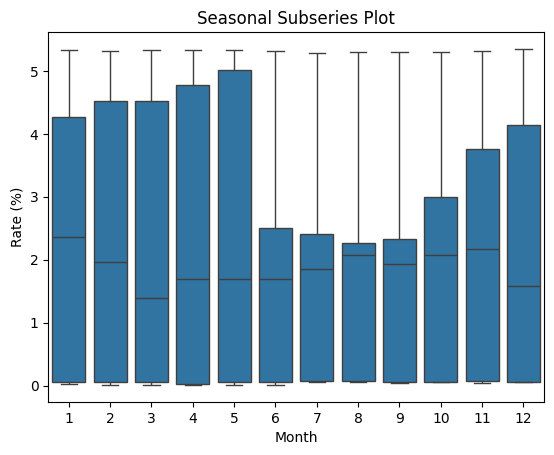

In [15]:
df_seasons['Month'] = df_seasons.index.month
sns.boxplot(x='Month', y='Rate (%)', data=df_seasons.reset_index())
plt.title('Seasonal Subseries Plot')
plt.xlabel('Month')
plt.ylabel('Rate (%)')
plt.show()

### ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) Plots

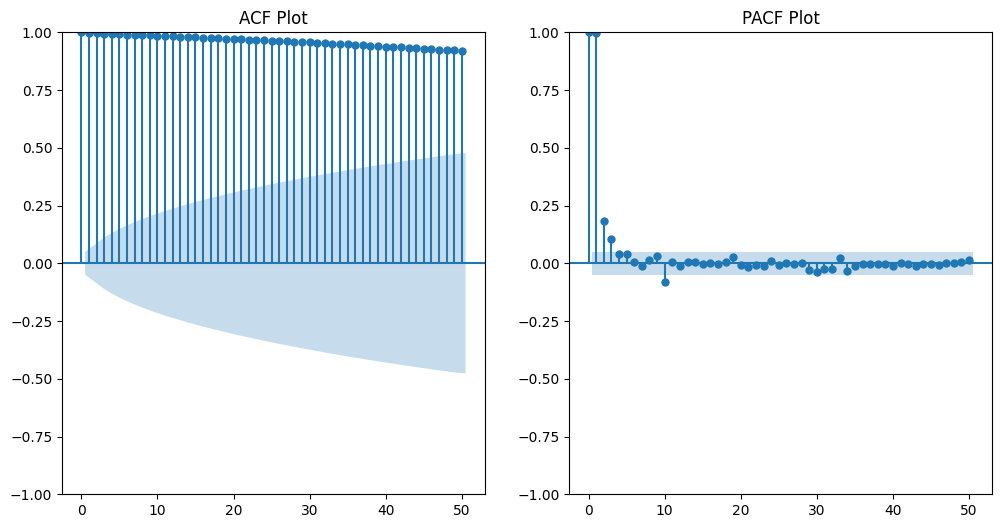

In [16]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_acf(df_seasons['Rate (%)'], lags=50, ax=plt.gca())
plt.title('ACF Plot')

plt.subplot(1, 2, 2)
plot_pacf(df_seasons['Rate (%)'], lags=50, ax=plt.gca())
plt.title('PACF Plot')
plt.show()

### Seasonal Decomposition (Cannot be performed due to missing daily figures)

In [17]:
# decomp_df = df_seasons.copy()
# decomp_df.index = pd.date_range(start=decomp_df.index.min(), end=decomp_df.index.max(), freq='D')

# result = seasonal_decompose(decomp_df['Rate (%)'], model='additive', period= 365)
# result.plot()
# plt.show()

In [18]:
# from statsmodels.tsa.seasonal import STL

# stl = STL(df_seasons['Rate (%)'], seasonal=13)
# result = stl.fit()
# result.plot()
# plt.show()

### Fourier Transform (Cannot be performed due to missing daily figures)

In [19]:
# from scipy.fftpack import fft
# import numpy as np

# # Number of observations
# N = len(df_seasons['Rate (%)'])
# # Frequency domain
# T = 1.0 / 365.0
# x = np.linspace(0.0, N*T, N, endpoint=False)
# yf = fft(df_seasons['Rate (%)'])
# xf = np.fft.fftfreq(N, T)[:N//2]

# plt.figure(figsize=(12, 6))
# plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
# plt.title('Fourier Transform')
# plt.xlabel('Frequency')
# plt.ylabel('Amplitude')
# plt.show()

### Seasonal Periodicity Test (Ljung-Box Test)

In [20]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test = acorr_ljungbox(df_seasons['Rate (%)'], lags=[12], return_df=True)
print(lb_test)


         lb_stat  lb_pvalue
12  18284.584561        0.0


some say yes some say no so will use SARIMAX instead

## Stationarity

### Check

In [21]:
def adf_test(series, title=''):
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key, value in result[4].items():
        out['Critical Value (%s)' % key] = value
    print(f'===Augmented Dickey-Fuller Test: {title}===')
    print(out.to_string())
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary")

def kpss_test(series, title=''):
    result = kpss(series.dropna(), regression='c')
    labels = ['KPSS Test Statistic', 'p-value', '#Lags Used']
    out = pd.Series(result[0:3], index=labels)
    for key, value in result[3].items():
        out['Critical Value (%s)' % key] = value
    print(f'===KPSS Test: {title}===')
    print(out.to_string())
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary")
    else:
        print("Weak evidence against the null hypothesis, time series is stationary")

In [22]:
df_stationary = df_final2.copy()

# Function to check stationarity and apply differencing
def ensure_stationarity(series, name):
    try:
        print(f"\nChecking stationarity for {name}:\n")
        adf_test(series, title=name)
        print("\n")
        kpss_test(series, title=name)

        # Check stationarity after the first differencing if necessary
        if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
            print(f"\n{name} is not stationary. Applying first differencing.\n")
            series = series.diff().dropna()

            # Ensure no infinite or NaN values
            if np.isinf(series).any() or series.isna().any():
                series.replace([np.inf, -np.inf], np.nan, inplace=True)
                series.dropna(inplace=True)

            print(f"\nRe-checking stationarity for {name} after first differencing:\n")
            adf_test(series, title=f"{name} - First Differenced")
            print("\n")
            kpss_test(series, title=f"{name} - First Differenced")

            # Check stationarity after the second differencing if necessary
            if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
                print(f"\n{name} is still not stationary. Applying second differencing.\n")
                series = series.diff().dropna()

                # Ensure no infinite or NaN values
                if np.isinf(series).any() or series.isna().any():
                    series.replace([np.inf, -np.inf], np.nan, inplace=True)
                    series.dropna(inplace=True)

                print(f"\nRe-checking stationarity for {name} after second differencing:\n")
                adf_test(series, title=f"{name} - Second Differenced")
                print("\n")
                kpss_test(series, title=f"{name} - Second Differenced")
            else:
                print(f"\n{name} is stationary after first differencing.\n")
        else:
            print(f"{name} is already stationary.\n")
    except Exception as e:
        print(f"An error occurred while processing {name}: {e}")

    return series

# Apply the function to each explanatory variable
for col in df_stationary.columns:
    if col not in ['Rate (%)', 'Rate (%) - First Differenced', 'Rate (%) - Second Differenced']:
        df_stationary[col] = ensure_stationarity(df_final2[col], col)

# Now, let's ensure the 'Rate (%)' column is also stationary, applying the same procedure
df_stationary['Rate (%)'] = ensure_stationarity(df_final2['Rate (%)'], 'Rate (%)')

print("Stationarity check and differencing completed.")


Checking stationarity for Volume ($Billions):

===Augmented Dickey-Fuller Test: Volume ($Billions)===
ADF Test Statistic                0.776581
p-value                           0.991249
#Lags Used                       13.000000
Number of Observations Used    1534.000000
Critical Value (1%)              -3.434620
Critical Value (5%)              -2.863426
Critical Value (10%)             -2.567774
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: Volume ($Billions)===
KPSS Test Statistic       2.145532
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary


<ipython-input-21-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



Volume ($Billions) is not stationary. Applying first differencing.


Re-checking stationarity for Volume ($Billions) after first differencing:

===Augmented Dickey-Fuller Test: Volume ($Billions) - First Differenced===
ADF Test Statistic            -1.265209e+01
p-value                        1.361381e-23
#Lags Used                     1.200000e+01
Number of Observations Used    1.534000e+03
Critical Value (1%)           -3.434620e+00
Critical Value (5%)           -2.863426e+00
Critical Value (10%)          -2.567774e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: Volume ($Billions) - First Differenced===
KPSS Test Statistic       0.381913
p-value                   0.084951
#Lags Used               21.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Weak evidence against the null hypothesis, time series i

<ipython-input-21-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')


===Augmented Dickey-Fuller Test: 4 WEEKS COUPON EQUIVALENT - First Differenced===
ADF Test Statistic            -7.201498e+00
p-value                        2.358997e-10
#Lags Used                     2.400000e+01
Number of Observations Used    1.522000e+03
Critical Value (1%)           -3.434654e+00
Critical Value (5%)           -2.863441e+00
Critical Value (10%)          -2.567782e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: 4 WEEKS COUPON EQUIVALENT - First Differenced===
KPSS Test Statistic       0.597240
p-value                   0.022887
#Lags Used               21.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

4 WEEKS COUPON EQUIVALENT is still not stationary. Applying second differencing.


Re-chec

<ipython-input-21-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-21-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



13 WEEKS COUPON EQUIVALENT is not stationary. Applying first differencing.


Re-checking stationarity for 13 WEEKS COUPON EQUIVALENT after first differencing:

===Augmented Dickey-Fuller Test: 13 WEEKS COUPON EQUIVALENT - First Differenced===
ADF Test Statistic            -5.993444e+00
p-value                        1.723783e-07
#Lags Used                     2.100000e+01
Number of Observations Used    1.525000e+03
Critical Value (1%)           -3.434645e+00
Critical Value (5%)           -2.863437e+00
Critical Value (10%)          -2.567780e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: 13 WEEKS COUPON EQUIVALENT - First Differenced===
KPSS Test Statistic       0.961744
p-value                   0.010000
#Lags Used               22.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against 

<ipython-input-21-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-22-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:



13 WEEKS COUPON EQUIVALENT is still not stationary. Applying second differencing.


Re-checking stationarity for 13 WEEKS COUPON EQUIVALENT after second differencing:

===Augmented Dickey-Fuller Test: 13 WEEKS COUPON EQUIVALENT - Second Differenced===
ADF Test Statistic            -1.321278e+01
p-value                        1.038910e-24
#Lags Used                     2.200000e+01
Number of Observations Used    1.523000e+03
Critical Value (1%)           -3.434651e+00
Critical Value (5%)           -2.863440e+00
Critical Value (10%)          -2.567781e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: 13 WEEKS COUPON EQUIVALENT - Second Differenced===
KPSS Test Statistic       0.013801
p-value                   0.100000
#Lags Used               28.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Weak evidence 

<ipython-input-21-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-21-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')


===Augmented Dickey-Fuller Test: 26 WEEKS COUPON EQUIVALENT===
ADF Test Statistic               -0.074878
p-value                           0.951884
#Lags Used                       20.000000
Number of Observations Used    1527.000000
Critical Value (1%)              -3.434640
Critical Value (5%)              -2.863435
Critical Value (10%)             -2.567779
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: 26 WEEKS COUPON EQUIVALENT===
KPSS Test Statistic       2.957931
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

26 WEEKS COUPON EQUIVALENT is not stationary. Applying first differencing.


Re-checking stationarity for 26 WEEKS COUPON EQUIVALENT after first

<ipython-input-21-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-22-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:



26 WEEKS COUPON EQUIVALENT is still not stationary. Applying second differencing.


Re-checking stationarity for 26 WEEKS COUPON EQUIVALENT after second differencing:

===Augmented Dickey-Fuller Test: 26 WEEKS COUPON EQUIVALENT - Second Differenced===
ADF Test Statistic            -1.521944e+01
p-value                        5.511491e-28
#Lags Used                     1.800000e+01
Number of Observations Used    1.527000e+03
Critical Value (1%)           -3.434640e+00
Critical Value (5%)           -2.863435e+00
Critical Value (10%)          -2.567779e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: 26 WEEKS COUPON EQUIVALENT - Second Differenced===
KPSS Test Statistic       0.005815
p-value                   0.100000
#Lags Used               16.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Weak evidence 

<ipython-input-21-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-21-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')


===Augmented Dickey-Fuller Test: 52 WEEKS COUPON EQUIVALENT===
ADF Test Statistic               -0.111524
p-value                           0.948279
#Lags Used                       22.000000
Number of Observations Used    1525.000000
Critical Value (1%)              -3.434645
Critical Value (5%)              -2.863437
Critical Value (10%)             -2.567780
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: 52 WEEKS COUPON EQUIVALENT===
KPSS Test Statistic       2.938602
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

52 WEEKS COUPON EQUIVALENT is not stationary. Applying first differencing.


Re-checking stationarity for 52 WEEKS COUPON EQUIVALENT after first

<ipython-input-21-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-22-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:


===Augmented Dickey-Fuller Test: 52 WEEKS COUPON EQUIVALENT - Second Differenced===
ADF Test Statistic            -1.478560e+01
p-value                        2.211103e-27
#Lags Used                     2.000000e+01
Number of Observations Used    1.525000e+03
Critical Value (1%)           -3.434645e+00
Critical Value (5%)           -2.863437e+00
Critical Value (10%)          -2.567780e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: 52 WEEKS COUPON EQUIVALENT - Second Differenced===
KPSS Test Statistic       0.016947
p-value                   0.100000
#Lags Used               50.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Weak evidence against the null hypothesis, time series is stationary

Checking stationarity for LT COMPOSITE (>10 Yrs):

===Augmented Dickey-Fuller Test: LT COMPOSITE (>10 Yrs)===
ADF

<ipython-input-21-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-21-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



LT COMPOSITE (>10 Yrs) is not stationary. Applying first differencing.


Re-checking stationarity for LT COMPOSITE (>10 Yrs) after first differencing:

===Augmented Dickey-Fuller Test: LT COMPOSITE (>10 Yrs) - First Differenced===
ADF Test Statistic              -29.642217
p-value                           0.000000
#Lags Used                        1.000000
Number of Observations Used    1545.000000
Critical Value (1%)              -3.434590
Critical Value (5%)              -2.863413
Critical Value (10%)             -2.567767
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: LT COMPOSITE (>10 Yrs) - First Differenced===
KPSS Test Statistic      0.312068
p-value                  0.100000
#Lags Used               1.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
Weak evidence against the null hypothesis, time series

<ipython-input-21-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-22-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:



LT COMPOSITE (>10 Yrs) is stationary after first differencing.


Checking stationarity for TREASURY 20-Yr CMT:

===Augmented Dickey-Fuller Test: TREASURY 20-Yr CMT===
ADF Test Statistic               -0.307270
p-value                           0.924468
#Lags Used                        2.000000
Number of Observations Used    1545.000000
Critical Value (1%)              -3.434590
Critical Value (5%)              -2.863413
Critical Value (10%)             -2.567767
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: TREASURY 20-Yr CMT===
KPSS Test Statistic       3.25098
p-value                   0.01000
#Lags Used               25.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary


<ipython-input-21-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



TREASURY 20-Yr CMT is not stationary. Applying first differencing.


Re-checking stationarity for TREASURY 20-Yr CMT after first differencing:

===Augmented Dickey-Fuller Test: TREASURY 20-Yr CMT - First Differenced===
ADF Test Statistic              -29.726862
p-value                           0.000000
#Lags Used                        1.000000
Number of Observations Used    1545.000000
Critical Value (1%)              -3.434590
Critical Value (5%)              -2.863413
Critical Value (10%)             -2.567767
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: TREASURY 20-Yr CMT - First Differenced===
KPSS Test Statistic      0.311121
p-value                  0.100000
#Lags Used               0.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
Weak evidence against the null hypothesis, time series is stationary


<ipython-input-21-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-22-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:



TREASURY 20-Yr CMT is stationary after first differencing.


Checking stationarity for Yield Spread (4W - 52W):

===Augmented Dickey-Fuller Test: Yield Spread (4W - 52W)===
ADF Test Statistic               -1.761954
p-value                           0.399507
#Lags Used                       23.000000
Number of Observations Used    1524.000000
Critical Value (1%)              -3.434648
Critical Value (5%)              -2.863438
Critical Value (10%)             -2.567781
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: Yield Spread (4W - 52W)===
KPSS Test Statistic       0.552794
p-value                   0.029776
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

Yield Spread (4W - 52W) is not stati

<ipython-input-21-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-22-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:



Yield Spread (4W - 52W) is stationary after first differencing.


Checking stationarity for Yield Spread (13W - 52W):

===Augmented Dickey-Fuller Test: Yield Spread (13W - 52W)===
ADF Test Statistic               -1.765429
p-value                           0.397755
#Lags Used                       23.000000
Number of Observations Used    1524.000000
Critical Value (1%)              -3.434648
Critical Value (5%)              -2.863438
Critical Value (10%)             -2.567781
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: Yield Spread (13W - 52W)===
KPSS Test Statistic       0.551603
p-value                   0.030044
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

Yield Spread (13W - 52W) is 

<ipython-input-21-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-22-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:



Yield Spread (13W - 52W) is stationary after first differencing.


Checking stationarity for Yield Spread (26W - 52W):

===Augmented Dickey-Fuller Test: Yield Spread (26W - 52W)===
ADF Test Statistic               -1.797696
p-value                           0.381606
#Lags Used                       23.000000
Number of Observations Used    1524.000000
Critical Value (1%)              -3.434648
Critical Value (5%)              -2.863438
Critical Value (10%)             -2.567781
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: Yield Spread (26W - 52W)===
KPSS Test Statistic       1.076525
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary


<ipython-input-21-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



Yield Spread (26W - 52W) is not stationary. Applying first differencing.


Re-checking stationarity for Yield Spread (26W - 52W) after first differencing:

===Augmented Dickey-Fuller Test: Yield Spread (26W - 52W) - First Differenced===
ADF Test Statistic            -8.362724e+00
p-value                        2.795353e-13
#Lags Used                     2.200000e+01
Number of Observations Used    1.524000e+03
Critical Value (1%)           -3.434648e+00
Critical Value (5%)           -2.863438e+00
Critical Value (10%)          -2.567781e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: Yield Spread (26W - 52W) - First Differenced===
KPSS Test Statistic       0.065045
p-value                   0.100000
#Lags Used               20.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Weak evidence against the null h

<ipython-input-21-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-22-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-21-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



Yield Spread (26W - 52W) is stationary after first differencing.


Checking stationarity for Yield Spread (10Y - 4W):

===Augmented Dickey-Fuller Test: Yield Spread (10Y - 4W)===
ADF Test Statistic               -0.991309
p-value                           0.756421
#Lags Used                       24.000000
Number of Observations Used    1523.000000
Critical Value (1%)              -3.434651
Critical Value (5%)              -2.863440
Critical Value (10%)             -2.567781
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: Yield Spread (10Y - 4W)===
KPSS Test Statistic       1.74669
p-value                   0.01000
#Lags Used               25.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

Yield Spread (10Y - 4W) is not statio

<ipython-input-21-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-22-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:



Yield Spread (10Y - 4W) is stationary after first differencing.


Checking stationarity for Yield Spread (20Y - 4W):

===Augmented Dickey-Fuller Test: Yield Spread (20Y - 4W)===
ADF Test Statistic               -0.999176
p-value                           0.753565
#Lags Used                       24.000000
Number of Observations Used    1523.000000
Critical Value (1%)              -3.434651
Critical Value (5%)              -2.863440
Critical Value (10%)             -2.567781
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: Yield Spread (20Y - 4W)===
KPSS Test Statistic       1.579764
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary


<ipython-input-21-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



Yield Spread (20Y - 4W) is not stationary. Applying first differencing.


Re-checking stationarity for Yield Spread (20Y - 4W) after first differencing:

===Augmented Dickey-Fuller Test: Yield Spread (20Y - 4W) - First Differenced===
ADF Test Statistic            -8.370157e+00
p-value                        2.675730e-13
#Lags Used                     2.300000e+01
Number of Observations Used    1.523000e+03
Critical Value (1%)           -3.434651e+00
Critical Value (5%)           -2.863440e+00
Critical Value (10%)          -2.567781e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary




<ipython-input-21-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-22-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:


===KPSS Test: Yield Spread (20Y - 4W) - First Differenced===
KPSS Test Statistic       0.13947
p-value                   0.10000
#Lags Used               17.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
Weak evidence against the null hypothesis, time series is stationary

Yield Spread (20Y - 4W) is stationary after first differencing.


Checking stationarity for Yield Spread (10Y - 52W):

===Augmented Dickey-Fuller Test: Yield Spread (10Y - 52W)===
ADF Test Statistic               -0.675197
p-value                           0.853070
#Lags Used                        4.000000
Number of Observations Used    1543.000000
Critical Value (1%)              -3.434595
Critical Value (5%)              -2.863415
Critical Value (10%)             -2.567768
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: Yield Spread (10Y - 52W)===
KP

<ipython-input-21-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')


===Augmented Dickey-Fuller Test: Yield Spread (10Y - 52W) - First Differenced===
ADF Test Statistic              -21.810181
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    1543.000000
Critical Value (1%)              -3.434595
Critical Value (5%)              -2.863415
Critical Value (10%)             -2.567768
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: Yield Spread (10Y - 52W) - First Differenced===
KPSS Test Statistic       0.228859
p-value                   0.100000
#Lags Used               14.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Weak evidence against the null hypothesis, time series is stationary

Yield Spread (10Y - 52W) is stationary after first differencing.


Checking stationarity for Yield Spread (20Y - 52W):



<ipython-input-21-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-22-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:


===Augmented Dickey-Fuller Test: Yield Spread (20Y - 52W)===
ADF Test Statistic               -0.677646
p-value                           0.852455
#Lags Used                        4.000000
Number of Observations Used    1543.000000
Critical Value (1%)              -3.434595
Critical Value (5%)              -2.863415
Critical Value (10%)             -2.567768
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: Yield Spread (20Y - 52W)===
KPSS Test Statistic       2.040066
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

Yield Spread (20Y - 52W) is not stationary. Applying first differencing.


Re-checking stationarity for Yield Spread (20Y - 52W) after first differe

<ipython-input-21-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')


===Augmented Dickey-Fuller Test: Yield Spread (20Y - 52W) - First Differenced===
ADF Test Statistic              -21.870394
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    1543.000000
Critical Value (1%)              -3.434595
Critical Value (5%)              -2.863415
Critical Value (10%)             -2.567768
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: Yield Spread (20Y - 52W) - First Differenced===
KPSS Test Statistic       0.24085
p-value                   0.10000
#Lags Used               14.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
Weak evidence against the null hypothesis, time series is stationary

Yield Spread (20Y - 52W) is stationary after first differencing.


Checking stationarity for CPI:



<ipython-input-21-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-22-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:


===Augmented Dickey-Fuller Test: CPI===
ADF Test Statistic                0.625158
p-value                           0.988220
#Lags Used                       23.000000
Number of Observations Used    1524.000000
Critical Value (1%)              -3.434648
Critical Value (5%)              -2.863438
Critical Value (10%)             -2.567781
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: CPI===
KPSS Test Statistic       5.8641
p-value                   0.0100
#Lags Used               25.0000
Critical Value (10%)      0.3470
Critical Value (5%)       0.4630
Critical Value (2.5%)     0.5740
Critical Value (1%)       0.7390
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

CPI is not stationary. Applying first differencing.


Re-checking stationarity for CPI after first differencing:



<ipython-input-21-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')


===Augmented Dickey-Fuller Test: CPI - First Differenced===
ADF Test Statistic               -4.734554
p-value                           0.000072
#Lags Used                       22.000000
Number of Observations Used    1524.000000
Critical Value (1%)              -3.434648
Critical Value (5%)              -2.863438
Critical Value (10%)             -2.567781
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: CPI - First Differenced===
KPSS Test Statistic       0.696258
p-value                   0.013886
#Lags Used               10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

CPI is still not stationary. Applying second differencing.


Re-checking stationarity for CPI after second differencing:

===Augmented Dickey

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2171: RuntimeWarning: divide by zero encountered in scalar divide
  s_hat = s1 / s0
<ipython-input-21-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



SPX is not stationary. Applying first differencing.


Re-checking stationarity for SPX after first differencing:

===Augmented Dickey-Fuller Test: SPX - First Differenced===
ADF Test Statistic            -1.219072e+01
p-value                        1.287629e-22
#Lags Used                     8.000000e+00
Number of Observations Used    1.538000e+03
Critical Value (1%)           -3.434609e+00
Critical Value (5%)           -2.863421e+00
Critical Value (10%)          -2.567771e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: SPX - First Differenced===
KPSS Test Statistic      0.073802
p-value                  0.100000
#Lags Used               0.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
Weak evidence against the null hypothesis, time series is stationary


<ipython-input-21-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-22-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:



SPX is stationary after first differencing.


Checking stationarity for NASDAQ:

===Augmented Dickey-Fuller Test: NASDAQ===
ADF Test Statistic               -0.461922
p-value                           0.899235
#Lags Used                        9.000000
Number of Observations Used    1538.000000
Critical Value (1%)              -3.434609
Critical Value (5%)              -2.863421
Critical Value (10%)             -2.567771
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: NASDAQ===
KPSS Test Statistic       4.37819
p-value                   0.01000
#Lags Used               25.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary


<ipython-input-21-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



NASDAQ is not stationary. Applying first differencing.


Re-checking stationarity for NASDAQ after first differencing:

===Augmented Dickey-Fuller Test: NASDAQ - First Differenced===
ADF Test Statistic            -1.260440e+01
p-value                        1.708370e-23
#Lags Used                     8.000000e+00
Number of Observations Used    1.538000e+03
Critical Value (1%)           -3.434609e+00
Critical Value (5%)           -2.863421e+00
Critical Value (10%)          -2.567771e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: NASDAQ - First Differenced===
KPSS Test Statistic      0.103482
p-value                  0.100000
#Lags Used               3.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
Weak evidence against the null hypothesis, time series is stationary


<ipython-input-21-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-22-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:



NASDAQ is stationary after first differencing.


Checking stationarity for DJIA:

===Augmented Dickey-Fuller Test: DJIA===
ADF Test Statistic               -1.223282
p-value                           0.663501
#Lags Used                        9.000000
Number of Observations Used    1538.000000
Critical Value (1%)              -3.434609
Critical Value (5%)              -2.863421
Critical Value (10%)             -2.567771
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: DJIA===
KPSS Test Statistic       4.897202
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary


<ipython-input-21-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



DJIA is not stationary. Applying first differencing.


Re-checking stationarity for DJIA after first differencing:

===Augmented Dickey-Fuller Test: DJIA - First Differenced===
ADF Test Statistic            -1.220702e+01
p-value                        1.187146e-22
#Lags Used                     8.000000e+00
Number of Observations Used    1.538000e+03
Critical Value (1%)           -3.434609e+00
Critical Value (5%)           -2.863421e+00
Critical Value (10%)          -2.567771e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: DJIA - First Differenced===
KPSS Test Statistic      0.032715
p-value                  0.100000
#Lags Used               5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
Weak evidence against the null hypothesis, time series is stationary


<ipython-input-21-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-22-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:



DJIA is stationary after first differencing.


Checking stationarity for SPOT EXCHANGE RATE - EURO AREA :

===Augmented Dickey-Fuller Test: SPOT EXCHANGE RATE - EURO AREA ===
ADF Test Statistic               -2.184473
p-value                           0.211929
#Lags Used                        6.000000
Number of Observations Used    1541.000000
Critical Value (1%)              -3.434601
Critical Value (5%)              -2.863417
Critical Value (10%)             -2.567769
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: SPOT EXCHANGE RATE - EURO AREA ===
KPSS Test Statistic       2.11942
p-value                   0.01000
#Lags Used               25.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary


<ipython-input-21-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



SPOT EXCHANGE RATE - EURO AREA  is not stationary. Applying first differencing.


Re-checking stationarity for SPOT EXCHANGE RATE - EURO AREA  after first differencing:

===Augmented Dickey-Fuller Test: SPOT EXCHANGE RATE - EURO AREA  - First Differenced===
ADF Test Statistic            -1.748117e+01
p-value                        4.488492e-30
#Lags Used                     5.000000e+00
Number of Observations Used    1.541000e+03
Critical Value (1%)           -3.434601e+00
Critical Value (5%)           -2.863417e+00
Critical Value (10%)          -2.567769e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: SPOT EXCHANGE RATE - EURO AREA  - First Differenced===
KPSS Test Statistic      0.087167
p-value                  0.100000
#Lags Used               2.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
Weak eviden

<ipython-input-21-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-22-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:



SPOT EXCHANGE RATE - EURO AREA  is stationary after first differencing.


Checking stationarity for UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK):

===Augmented Dickey-Fuller Test: UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)===
ADF Test Statistic               -2.766211
p-value                           0.063265
#Lags Used                       11.000000
Number of Observations Used    1536.000000
Critical Value (1%)              -3.434614
Critical Value (5%)              -2.863424
Critical Value (10%)             -2.567773
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)===
KPSS Test Statistic       1.064572
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Str

<ipython-input-21-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK) is not stationary. Applying first differencing.


Re-checking stationarity for UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK) after first differencing:

===Augmented Dickey-Fuller Test: UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK) - First Differenced===
ADF Test Statistic            -1.243071e+01
p-value                        3.946348e-23
#Lags Used                     1.000000e+01
Number of Observations Used    1.536000e+03
Critical Value (1%)           -3.434614e+00
Critical Value (5%)           -2.863424e+00
Critical Value (10%)          -2.567773e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK) - First Differenced===
KPSS Test Statistic      0.072704
p-value                  0.100000
#Lags Used               4.000000
Critical Value (10%)   

<ipython-input-21-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-22-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:



UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK) is stationary after first differencing.


Checking stationarity for CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R. :

===Augmented Dickey-Fuller Test: CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R. ===
ADF Test Statistic               -1.865608
p-value                           0.348409
#Lags Used                       14.000000
Number of Observations Used    1533.000000
Critical Value (1%)              -3.434623
Critical Value (5%)              -2.863427
Critical Value (10%)             -2.567775
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R. ===
KPSS Test Statistic       1.202374
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the n

<ipython-input-21-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.  is not stationary. Applying first differencing.


Re-checking stationarity for CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.  after first differencing:

===Augmented Dickey-Fuller Test: CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.  - First Differenced===
ADF Test Statistic            -1.815930e+01
p-value                        2.463800e-30
#Lags Used                     3.000000e+00
Number of Observations Used    1.543000e+03
Critical Value (1%)           -3.434595e+00
Critical Value (5%)           -2.863415e+00
Critical Value (10%)          -2.567768e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.  - First Differenced===
KPSS Test Statistic      0.183514
p-value                  0.100000
#Lags Used               9.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.5740

<ipython-input-21-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-22-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:



CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.  is stationary after first differencing.


Checking stationarity for JAPAN -- SPOT EXCHANGE RATE, YEN/US$ :

===Augmented Dickey-Fuller Test: JAPAN -- SPOT EXCHANGE RATE, YEN/US$ ===
ADF Test Statistic                0.827972
p-value                           0.992075
#Lags Used                        3.000000
Number of Observations Used    1544.000000
Critical Value (1%)              -3.434592
Critical Value (5%)              -2.863414
Critical Value (10%)             -2.567768
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: JAPAN -- SPOT EXCHANGE RATE, YEN/US$ ===
KPSS Test Statistic       4.756523
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypot

<ipython-input-21-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



JAPAN -- SPOT EXCHANGE RATE, YEN/US$  is not stationary. Applying first differencing.


Re-checking stationarity for JAPAN -- SPOT EXCHANGE RATE, YEN/US$  after first differencing:

===Augmented Dickey-Fuller Test: JAPAN -- SPOT EXCHANGE RATE, YEN/US$  - First Differenced===
ADF Test Statistic              -24.439407
p-value                           0.000000
#Lags Used                        2.000000
Number of Observations Used    1544.000000
Critical Value (1%)              -3.434592
Critical Value (5%)              -2.863414
Critical Value (10%)             -2.567768
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: JAPAN -- SPOT EXCHANGE RATE, YEN/US$  - First Differenced===
KPSS Test Statistic      0.318369
p-value                  0.100000
#Lags Used               3.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.7

<ipython-input-21-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-22-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:



JAPAN -- SPOT EXCHANGE RATE, YEN/US$  is stationary after first differencing.


Checking stationarity for Rate (%):

===Augmented Dickey-Fuller Test: Rate (%)===
ADF Test Statistic                0.509674
p-value                           0.985164
#Lags Used                        9.000000
Number of Observations Used    1538.000000
Critical Value (1%)              -3.434609
Critical Value (5%)              -2.863421
Critical Value (10%)             -2.567771
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: Rate (%)===
KPSS Test Statistic       2.705655
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary


<ipython-input-21-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



Rate (%) is not stationary. Applying first differencing.


Re-checking stationarity for Rate (%) after first differencing:

===Augmented Dickey-Fuller Test: Rate (%) - First Differenced===
ADF Test Statistic            -1.451373e+01
p-value                        5.669389e-27
#Lags Used                     8.000000e+00
Number of Observations Used    1.538000e+03
Critical Value (1%)           -3.434609e+00
Critical Value (5%)           -2.863421e+00
Critical Value (10%)          -2.567771e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: Rate (%) - First Differenced===
KPSS Test Statistic       0.641104
p-value                   0.018900
#Lags Used               40.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary


<ipython-input-21-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')


### Summary

In [23]:
# Initialize a list to store results
results = []

# Function to check stationarity and apply differencing
def check_stationarity(series, name):
    differencing_count = 0

    def adf_test(series):
        return adfuller(series.dropna(), autolag='AIC')[1]

    def kpss_test(series):
        return kpss(series.dropna(), regression='c')[1]

    try:
        adf_p_value = adf_test(series)
        kpss_p_value = kpss_test(series)

        # Check initial stationarity
        if adf_p_value > 0.05 or kpss_p_value <= 0.05:
            # Apply first differencing
            series = series.diff().dropna()
            differencing_count = 1
            adf_p_value = adf_test(series)
            kpss_p_value = kpss_test(series)

            if adf_p_value > 0.05 or kpss_p_value <= 0.05:
                # Apply second differencing
                series = series.diff().dropna()
                differencing_count = 2
                adf_p_value = adf_test(series)
                kpss_p_value = kpss_test(series)

            # Determine stationarity after all differencing attempts
            if adf_p_value <= 0.05 and kpss_p_value > 0.05:
                stationary_status = 'Yes'
            else:
                stationary_status = 'No'
        else:
            stationary_status = 'Yes'

        # Collect results
        results.append({
            'Column Name': name,
            'Stationary': stationary_status,
            'Number of Differencing Needed': differencing_count
        })
    except Exception as e:
        print(f"An error occurred while processing {name}: {e}")
        results.append({
            'Column Name': name,
            'Stationary': 'Error',
            'Number of Differencing Needed': np.nan
        })

# Apply the function to each feature
for col in df_final2.columns:
    if col not in ['Rate (%)', 'Rate (%) - Differenced']:
        check_stationarity(df_final2[col], col)

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Display the results DataFrame
print("Stationarity check and differencing summary:\n\n")
results_df

<ipython-input-23-1a61a9a6502f>:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(series.dropna(), regression='c')[1]
<ipython-input-23-1a61a9a6502f>:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(series.dropna(), regression='c')[1]
<ipython-input-23-1a61a9a6502f>:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  return kpss(series.dropna(), regression='c')[1]
<ipython-input-23-1a61a9a6502f>:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(series.dropna(), regress

An error occurred while processing CPI: cannot convert float infinity to integer


<ipython-input-23-1a61a9a6502f>:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(series.dropna(), regression='c')[1]
<ipython-input-23-1a61a9a6502f>:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  return kpss(series.dropna(), regression='c')[1]
<ipython-input-23-1a61a9a6502f>:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(series.dropna(), regression='c')[1]
<ipython-input-23-1a61a9a6502f>:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  return kpss(series.dropna(), regress

Stationarity check and differencing summary:




<ipython-input-23-1a61a9a6502f>:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  return kpss(series.dropna(), regression='c')[1]


,Column Name,Stationary,Number of Differencing Needed
0,Volume ($Billions),Yes,1.0
1,4 WEEKS COUPON EQUIVALENT,Yes,2.0
2,13 WEEKS COUPON EQUIVALENT,Yes,2.0
3,26 WEEKS COUPON EQUIVALENT,Yes,2.0
4,52 WEEKS COUPON EQUIVALENT,Yes,2.0
5,LT COMPOSITE (>10 Yrs),Yes,1.0
6,TREASURY 20-Yr CMT,Yes,1.0
7,Yield Spread (4W - 52W),Yes,1.0
8,Yield Spread (13W - 52W),Yes,1.0
9,Yield Spread (26W - 52W),Yes,1.0


## Feature Engineering

### Creating Lagged and Difference Features

In [36]:
# Define a function to create lag features
def create_lag_features(df, lags, cols):
    for col in cols:
        for lag in lags:
            df[f'{col} - Lag{lag}'] = df[col].shift(lag)
    return df

# Define a function to create differenced features
def create_differenced_features(df, cols_for_first_diff, cols_for_second_diff):
    for col in cols_for_first_diff:
        df[f'{col} - First Differenced'] = df[col].diff()
    for col in cols_for_second_diff:
        df[f'{col} - Second Differenced'] = df[col].diff().diff()
    return df

# Apply differencing and lag feature creation to the DataFrame
def prepare_features(df, cols_for_first_diff, cols_for_second_diff):
    # Columns for which lag features will be created
    cols_for_lags = list(set(df.columns) - set(cols_for_first_diff + cols_for_second_diff))
    cols_for_lags += cols_for_first_diff + cols_for_second_diff  # Ensure all relevant columns are included

    # Create differenced features
    df = create_differenced_features(df, cols_for_first_diff, cols_for_second_diff)

    # Create lag features
    lags = [1, 2, 3, 7, 14]  # Adjust the list of lags based on your needs
    df = create_lag_features(df, lags, cols_for_lags)

    # Drop rows with NaN values created by differencing and lagging
    df.dropna(inplace=True)

    return df

# Specify the columns for first and second differencing
cols_for_first_diff = ['Volume ($Billions)','LT COMPOSITE (>10 Yrs)','TREASURY 20-Yr CMT',
                       'Yield Spread (4W - 52W)','Yield Spread (13W - 52W)','Yield Spread (26W - 52W)',
                       'Yield Spread (10Y - 4W)','Yield Spread (20Y - 4W)','Yield Spread (10Y - 52W)',
                       'Yield Spread (20Y - 52W)','SPX','NASDAQ','DJIA','SPOT EXCHANGE RATE - EURO AREA ',
                       'UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)','CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R. ',
                       'JAPAN -- SPOT EXCHANGE RATE, YEN/US$ ']  # Replace with actual column names that need first differencing

cols_for_second_diff = ['4 WEEKS COUPON EQUIVALENT', '13 WEEKS COUPON EQUIVALENT',
                        '26 WEEKS COUPON EQUIVALENT', '52 WEEKS COUPON EQUIVALENT',
                        'CPI', 'Rate (%)']  # Replace with actual column names that need second differencing

# Prepare the features
df_prepared = prepare_features(df_final2.copy(), cols_for_first_diff, cols_for_second_diff)

print("Feature preparation (differencing and lag features) completed.\n\n")
df_prepared.head()

Feature preparation (differencing and lag features) completed.




<ipython-input-36-23e968d9d660>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col} - Lag{lag}'] = df[col].shift(lag)
<ipython-input-36-23e968d9d660>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col} - Lag{lag}'] = df[col].shift(lag)
<ipython-input-36-23e968d9d660>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, 

,Rate (%),Volume ($Billions),4 WEEKS COUPON EQUIVALENT,13 WEEKS COUPON EQUIVALENT,26 WEEKS COUPON EQUIVALENT,52 WEEKS COUPON EQUIVALENT,LT COMPOSITE (>10 Yrs),TREASURY 20-Yr CMT,Yield Spread (4W - 52W),Yield Spread (13W - 52W),...,CPI - Lag1,CPI - Lag2,CPI - Lag3,CPI - Lag7,CPI - Lag14,Rate (%) - Lag1,Rate (%) - Lag2,Rate (%) - Lag3,Rate (%) - Lag7,Rate (%) - Lag14
Date,,,,,,,,,,,,,,,,,,,,,
2018-04-20,1.67,340,1.64,1.81,2.01,2.20,3.09,3.04,0.56,0.39,...,250.546,250.546,250.546,250.546,250.546,1.67,1.69,1.70,1.70,1.77
2018-04-23,1.67,348,1.66,1.87,2.04,2.22,3.10,3.05,0.56,0.35,...,250.546,250.546,250.546,250.546,250.546,1.67,1.67,1.69,1.68,1.81
2018-04-24,1.68,339,1.70,1.87,2.05,2.25,3.12,3.08,0.55,0.38,...,250.546,250.546,250.546,250.546,250.546,1.67,1.67,1.67,1.68,1.70
2018-04-25,1.67,345,1.64,1.85,2.03,2.26,3.16,3.12,0.62,0.41,...,250.546,250.546,250.546,250.546,250.546,1.68,1.67,1.67,1.70,1.70
2018-04-26,1.67,333,1.61,1.82,2.02,2.25,3.13,3.08,0.64,0.43,...,250.546,250.546,250.546,250.546,250.546,1.67,1.68,1.67,1.70,1.70


### Feature Selection - Correlation Matrix

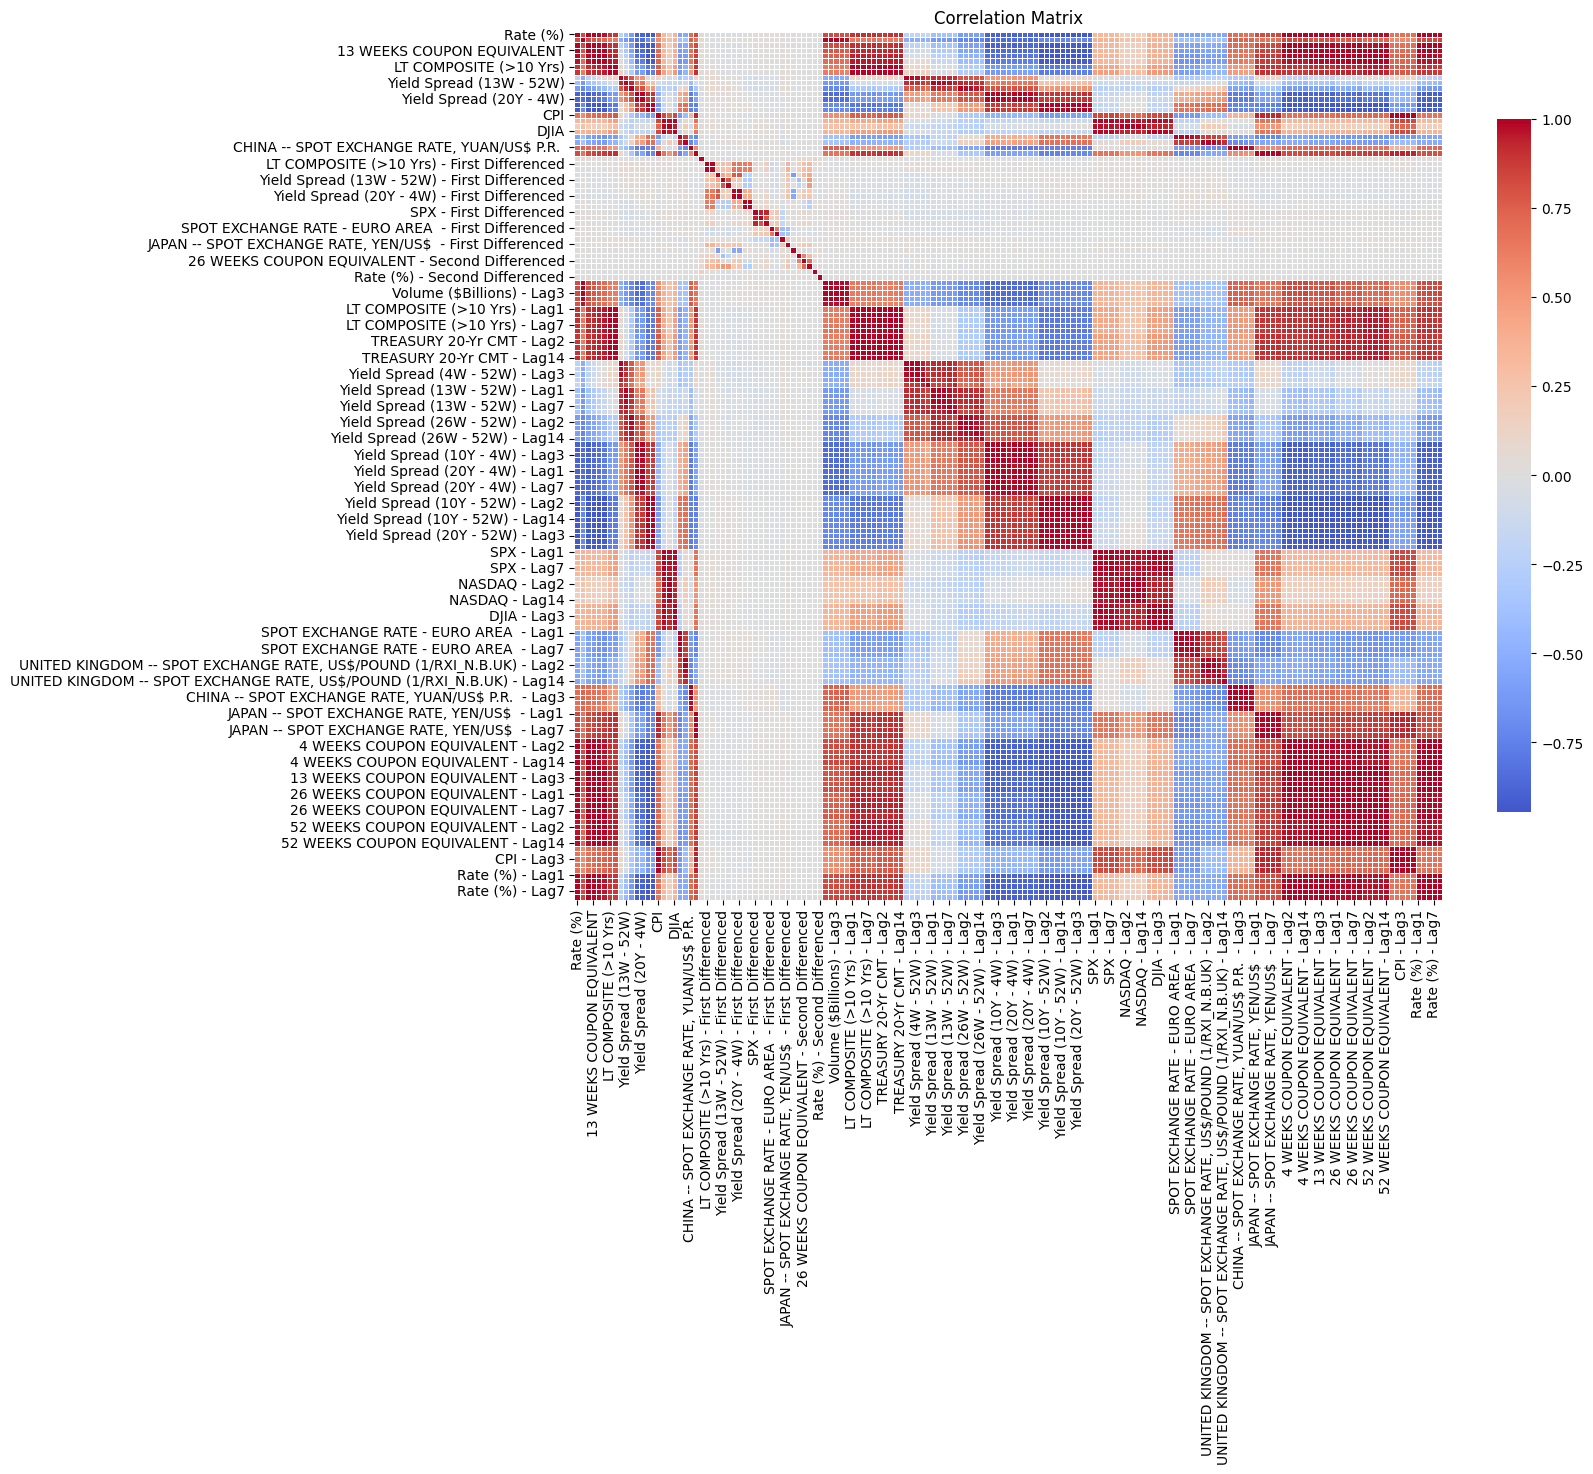

In [38]:
# Calculate the correlation matrix
correlation_matrix = df_prepared.corr()

# Plot the heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=False, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .75})
plt.title('Correlation Matrix')
plt.show()

### Feature Selection - Tree-Based Methods

In [39]:
# Assume df_prepared is your DataFrame with features and target
X = df_prepared.drop(columns=['Rate (%)'])  # Features
y = df_prepared['Rate (%)']  # Target

# Fit a Random Forest model
model = RandomForestRegressor()
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_

# Create a DataFrame to view feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importances:\n")
feature_importance_df.sort_values(by='Importance', ascending=False)

Feature Importances:



,Feature,Importance
154,CPI - Lag14,3.350286e-01
94,Yield Spread (20Y - 52W) - Lag14,2.951483e-01
138,13 WEEKS COUPON EQUIVALENT - Lag7,9.447707e-02
155,Rate (%) - Lag1,9.237816e-02
137,13 WEEKS COUPON EQUIVALENT - Lag3,6.614988e-02
...,...,...
74,Yield Spread (26W - 52W) - Lag14,7.875579e-07
24,TREASURY 20-Yr CMT - First Differenced,6.865952e-07
43,CPI - Second Differenced,6.185698e-07
32,SPX - First Differenced,4.773980e-07


In [40]:
total_importance = feature_importance_df['Importance'].sum()
feature_importance_df['Cumulative Importance'] = feature_importance_df['Importance'].cumsum()
cutoff = 0.90 * total_importance
important_features = feature_importance_df[feature_importance_df['Cumulative Importance'] <= cutoff]
important_features

,Feature,Importance,Cumulative Importance
154,CPI - Lag14,0.335029,0.335029
94,Yield Spread (20Y - 52W) - Lag14,0.295148,0.630177
138,13 WEEKS COUPON EQUIVALENT - Lag7,0.094477,0.724654
155,Rate (%) - Lag1,0.092378,0.817032
137,13 WEEKS COUPON EQUIVALENT - Lag3,0.066150,0.883182


### Feature Selection - Recursive Feature Elimination

In [45]:
# Fit RFE with a linear model
selector = RFE(LinearRegression(), n_features_to_select=10) # change to add more features
selector = selector.fit(X, y)

# Print selected features
selected_features = X.columns[selector.support_]
print("Selected Features:\n", selected_features)

Selected Features:
 Index(['LT COMPOSITE (>10 Yrs)', 'Rate (%) - Second Differenced',
       'LT COMPOSITE (>10 Yrs) - Lag2', 'TREASURY 20-Yr CMT - Lag1',
       'Yield Spread (20Y - 4W) - Lag7', 'Yield Spread (10Y - 52W) - Lag2',
       'SPOT EXCHANGE RATE - EURO AREA  - Lag2',
       '13 WEEKS COUPON EQUIVALENT - Lag1', 'Rate (%) - Lag1',
       'Rate (%) - Lag2'],
      dtype='object')


In [46]:
# Combine results
rfe_features_set = set(selected_features)
tree_features_set = set(feature_importance_df['Feature'].iloc[:10])  # Top 10 features from Random Forest

# Intersection of features
common_features = rfe_features_set & tree_features_set
print("Common features selected by both methods:")
print(common_features)

Common features selected by both methods:
{'Rate (%) - Lag1'}
